# Using RePP to Predict Pass Rusher Impact as Plays Develop
*RePP: **Re**current **P**ressure **P**robabilities*

**Jon Skaza & Matt Guthrie**

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image
import random
seed = 314 # for reproducibility, used in various places
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
try:
  from google.colab import drive
  in_colab = True
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="grpc://" + os.environ["COLAB_TPU_ADDR"])
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
except:
  in_colab = False

# run this once
# !apt install imagemagick

## Dataset Preprocessing

In [ ]:
if in_colab:
  drive.mount("/content/drive")
  path = "/content/drive/MyDrive/nfl-big-data-bowl-2023"
else:
  path = os.environ.get("BIG_DATA_BOWL")

df = pd.read_csv(f"{path}/data/dataset.csv", index_col=0)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,game_id,play_id,nfl_id,speed,pressure,x,y,dist_from_qb,qb_in_tackle_box,n_blockers,...,speed_qb,x_qb,y_qb,x_ball,y_ball,quarter,down,yards_to_go,absolute_yardline_number,score_delta
1,2021090900,97,41263,0.96,1,1.74,-5.03,7.802083,1.0,5,...,0.35,-3.92,0.34,0.00,0.00,1,3,2,43.0,0
2,2021090900,97,41263,1.08,1,1.63,-5.01,7.766557,1.0,5,...,0.54,-4.00,0.34,-0.49,0.02,1,3,2,43.0,0
3,2021090900,97,41263,1.30,1,1.47,-4.99,7.695193,1.0,5,...,0.80,-4.09,0.33,-0.85,0.03,1,3,2,43.0,0
4,2021090900,97,41263,1.48,1,1.31,-4.94,7.603138,1.0,5,...,0.99,-4.18,0.32,-1.29,0.05,1,3,2,43.0,0
5,2021090900,97,41263,2.16,1,1.04,-4.83,7.404627,1.0,5,...,1.19,-4.29,0.31,-1.77,0.06,1,3,2,43.0,0


In [ ]:
# examine missingness, models will need balanced sequences
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1077605 entries, 1 to 1077605
Data columns (total 30 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   game_id                   1077605 non-null  int64  
 1   play_id                   1077605 non-null  int64  
 2   nfl_id                    1077605 non-null  int64  
 3   speed                     1077605 non-null  float64
 4   pressure                  1077605 non-null  int64  
 5   x                         1077605 non-null  float64
 6   y                         1077605 non-null  float64
 7   dist_from_qb              1077605 non-null  float64
 8   qb_in_tackle_box          1077333 non-null  float64
 9   n_blockers                1077605 non-null  int64  
 10  x_C                       1077605 non-null  float64
 11  x_LT                      1077605 non-null  float64
 12  x_LG                      1077605 non-null  float64
 13  x_RG                      1

In [ ]:
df.dropna(axis = 0, how = "any", inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1077203 entries, 1 to 1077605
Data columns (total 30 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   game_id                   1077203 non-null  int64  
 1   play_id                   1077203 non-null  int64  
 2   nfl_id                    1077203 non-null  int64  
 3   speed                     1077203 non-null  float64
 4   pressure                  1077203 non-null  int64  
 5   x                         1077203 non-null  float64
 6   y                         1077203 non-null  float64
 7   dist_from_qb              1077203 non-null  float64
 8   qb_in_tackle_box          1077203 non-null  float64
 9   n_blockers                1077203 non-null  int64  
 10  x_C                       1077203 non-null  float64
 11  x_LT                      1077203 non-null  float64
 12  x_LG                      1077203 non-null  float64
 13  x_RG                      1

In [ ]:
def oversampler(df: pd.DataFrame, group_by: list, feats: list, outcome: str) -> pd.DataFrame:
    grouped_df = df.copy().groupby(group_by)
    group_labels = grouped_df.first()[outcome]
    vals = group_labels.value_counts()
    n_to_add = vals[0] - vals[1]
    minority_lab = vals.index[1]
    groups_to_sample = list(group_labels[group_labels == minority_lab].index)
    choices = [random.choice(groups_to_sample) for _ in range(n_to_add)]
    unique_key_counter = -1 # new "keys" will be negative so as not to duplicate groups which are all positive
    samples = []
    for i in choices:
        to_add = grouped_df.get_group(i).copy()
        for j in group_by:
            to_add[j] = unique_key_counter
        samples.append(to_add)
        unique_key_counter += -1
    return pd.concat([df] + samples, axis = 0)

In [ ]:
def make_datasets(df: pd.DataFrame, group_by: list, feats: list, outcome: str, sequences: bool, 
samples: int, test_size: float, oversample = False):

  if oversample:
    df = oversampler(df, group_by, feats, outcome)

  if sequences or samples > 0:
    X, y  = [], []
    grouped_df = df.groupby(group_by)
    for _, group_df in grouped_df:
      f = group_df[feats].to_numpy()
      if samples > 0:
        sub_seq_lens = np.random.randint(0, len(f), samples)
        sub_seq = [f[:n] for n in sub_seq_lens]
        X += sub_seq
      else: # sequences but no sampling
        X.append(group_df[feats].to_numpy())
      if sequences:
        if samples == 0:
          y.append(group_df[[outcome]].to_numpy()[0])
        else:
          for s in range(samples):
            y.append(group_df[[outcome]].to_numpy()[0])
      else: # no sequences but multiple samples
        y.append(np.repeat(group_df[outcome].values[0], sum(sub_seq_lens)))
    if sequences:
      X = tf.keras.utils.pad_sequences(X, dtype="float", padding="pre", value = -99)
      y = np.stack(y)
    else: # no sequences but multiple samples
      X = np.concatenate(X)
      y = np.concatenate(y).ravel()

  else:
      X = df[feats].to_numpy()
      y = df[outcome].to_numpy()
  
  print(f"X: {X.shape}")
  print(f"y: {y.shape}")
  return train_test_split(X, y, test_size = test_size, random_state = seed) + [outcome]

In [ ]:
outcome = "pressure"
group_by = ["game_id", "play_id", "nfl_id"]
feats = [x for x in list(df.columns) if x not in group_by + [outcome]]

## RePP: **Re**current **P**ressure **P**robabilities

### "Naive" Logistic Model

In [ ]:
def model_logistic(data: list, max_iter: int):
    mod = LogisticRegression(max_iter = max_iter)
    mod.fit(data[0], data[2])
    return mod

In [ ]:
data_logistic = make_datasets(df, group_by, feats, outcome, sequences = False, samples = 2, test_size = 0.2, oversample = True)
mod1 = model_logistic(data_logistic, 1000)

X: (2062242, 26)
y: (2062242,)


### LSTM

In [ ]:
def model_lstm(data: list, units: int, num_epochs: int, val: float):
    def build_model():
      mod = tf.keras.Sequential()
      mod.add(tf.keras.layers.Masking(mask_value= -99., input_shape= data[0].shape[1:]))
      mod.add(tf.keras.layers.LSTM(units, input_shape = data[0].shape[1:]))
      mod.add(tf.keras.layers.Dense(data[2].shape[1], activation="sigmoid"))

      mod.compile(loss = "binary_crossentropy", optimizer="adam",
      metrics = [tf.keras.metrics.AUC(), tf.keras.metrics.BinaryAccuracy()])
      return mod
    if in_colab:
      strategy = tf.distribute.TPUStrategy(resolver)
      with strategy.scope():
        mod = build_model()
    else:
      mod = build_model()
      
    callbacks = [tf.keras.callbacks.EarlyStopping(patience = 5, min_delta = 0.005,  monitor = "val_auc", restore_best_weights = True)]

    mod.fit(data[0], data[2], epochs = num_epochs, validation_split = val, verbose = 1, callbacks = callbacks)
    return mod

In [ ]:
data_ann = make_datasets(df, group_by, feats, outcome, sequences = True, samples = 2, test_size = 0.2, oversample = True)
mod2 = model_lstm(data_ann, 64, 150, 0.1)

X: (121932, 185, 26)
y: (121932, 1)
Epoch 1/150
2744/2744 [==============================] - 86s 29ms/step - loss: 0.6129 - auc: 0.7068 - binary_accuracy: 0.6462 - val_loss: 0.5851 - val_auc: 0.7475 - val_binary_accuracy: 0.6734
Epoch 2/150
2744/2744 [==============================] - 74s 27ms/step - loss: 0.5827 - auc: 0.7459 - binary_accuracy: 0.6728 - val_loss: 0.5653 - val_auc: 0.7643 - val_binary_accuracy: 0.6928
Epoch 3/150
2744/2744 [==============================] - 74s 27ms/step - loss: 0.5719 - auc: 0.7578 - binary_accuracy: 0.6822 - val_loss: 0.5623 - val_auc: 0.7704 - val_binary_accuracy: 0.6951
Epoch 4/150
2744/2744 [==============================] - 75s 27ms/step - loss: 0.5660 - auc: 0.7634 - binary_accuracy: 0.6861 - val_loss: 0.5612 - val_auc: 0.7745 - val_binary_accuracy: 0.6937
Epoch 5/150
2744/2744 [==============================] - 75s 27ms/step - loss: 0.5591 - auc: 0.7711 - binary_accuracy: 0.6933 - val_loss: 0.5517 - val_auc: 0.7807 - val_binary_accuracy: 0.6996

## Model Comparison

763/763 [==============================] - 8s 10ms/step


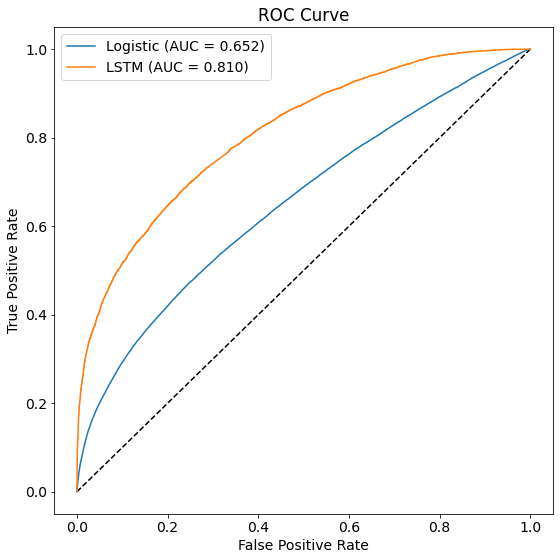

In [ ]:
def gen_roc_logistic(mod, data):
    y_pred = mod.predict_proba(data[1])[:,1].ravel()
    fpr, tpr, _ = roc_curve(data[3], y_pred)
    return fpr, tpr

def gen_roc_keras(mod, data):
    y_pred = mod.predict(data[1]).ravel()
    fpr, tpr, _ = roc_curve(data[3], y_pred)
    return fpr, tpr


plt.figure(1)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
fpr_logistic, tpr_logistic = gen_roc_logistic(mod1, data_logistic)
auc_logistic = auc(fpr_logistic, tpr_logistic)
plt.plot(fpr_logistic, tpr_logistic, label=f"Logistic (AUC = {auc_logistic:0.3f})")
fpr_keras, tpr_keras = gen_roc_keras(mod2, data_ann)
auc_keras= auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras, label=f"LSTM (AUC = {auc_keras:0.3f})")
plt.legend(loc="best")
plt.rcParams["figure.figsize"] = [12,9]
plt.rcParams["font.size"] = 14
plt.savefig("images/roc.png")
plt.show()

## Example Plays

In [ ]:
def make_probs(df, model, game_id, play_id, nfl_id):
  X, y  = [], []
  rush_df = df[(df["game_id"]==game_id) & (df["play_id"]==play_id) & (df["nfl_id"]==nfl_id)]

  f = rush_df[feats].to_numpy()
  
  if type(model) == LogisticRegression:
    X = rush_df[feats].to_numpy()
    return f, model.predict_proba(X)[:,1]
  
  else:
    sub_seq = [f[:n + 1] for n in range(len(f))]
    
    X = tf.keras.utils.pad_sequences(sub_seq, dtype="float", padding="pre", value = -99, maxlen=model.layers[0].output_shape[1])
    return f, model.predict(X).flatten()

In [ ]:
def path_plot(rush, probs, game_id, play_id, player_id, player_name):
  plt.ioff()

  # rush comparison animation 
  lim_x = 15
  lim_y = 10
  plt.rcParams["figure.figsize"] = [13, 8]
  plt.rcParams["figure.autolayout"] = True
  fig, ax = plt.subplots()
  ax.set_xlim(-10,lim_x)
  ax.set_ylim(-lim_y,lim_y)
  ax.set_facecolor('#008013')
  ax.tick_params(axis='y', colors='w')
  xtick_loc = [-10, -5, 5, 10, 15]
  ax.set_xticks(xtick_loc)
  markersize=20

  los, = ax.plot([],[], 'w', lw=2)
  los_neg5, = ax.plot([],[], 'w', lw=1)
  los_pos5, = ax.plot([],[], 'w', lw=1)
  los_pos10, = ax.plot([],[], 'w', lw=1)

  line_qb, = ax.plot([],[], 'b', lw=2)
  pt_qb, = ax.plot([],[], 'pb', markersize=markersize)
  line_C, = ax.plot([],[], 'b')
  pt_C, = ax.plot([],[], 'ob', markersize=markersize)
  line_LT, = ax.plot([],[], 'b')
  pt_LT, = ax.plot([],[], 'ob', markersize=markersize)
  line_LG, = ax.plot([],[], 'b')
  pt_LG, = ax.plot([],[], 'ob', markersize=markersize)
  line_RG, = ax.plot([],[], 'b')
  pt_RG, = ax.plot([],[], 'ob', markersize=markersize)
  line_RT, = ax.plot([],[], 'b')
  pt_RT, = ax.plot([],[], 'ob', markersize=markersize)

  line_ball, = ax.plot([],[], 'y', lw=3)
  pt_ball, = ax.plot([],[], '^y', markersize=markersize)

  line_rusher, = ax.plot([],[], 'r', lw=3)
  pt_rusher, = ax.plot([],[], 'or', markersize=markersize)

  prob_label = ax.text(2.5, -(lim_y - (lim_y *0.1)), "", ha='center', va='bottom', fontsize=25, bbox = (dict(facecolor='white', alpha=1)))
  label = ax.text(-9.2, lim_y - (lim_y *0.1), "", ha='left', va='top', fontsize=11, bbox = (dict(facecolor='white', alpha=1)))


  max_prob_frame = np.argmax(probs)


  def animate(i):
      los.set_data([0, 0], [-10, 10])
      los_neg5.set_data([-5, -5], [-10, 10])
      los_pos5.set_data([5, 5], [-10, 10])
      los_pos10.set_data([10, 10], [-10, 10])

      label.set_text(f"""Game: {game_id}
Play: {play_id}
Player: {player_id} ({player_name})
Frame: {i + 1}""")
      
      prob_label.set_text(f"Pressure Probability: {int(probs[i] * 100)}%")
      
      line_qb.set_xdata(-rush[:i+1,17])
      line_qb.set_ydata(-rush[:i+1,18])
      pt_qb.set_xdata(-rush[i,17])
      pt_qb.set_ydata(-rush[i,18])

      line_C.set_xdata(-rush[:i+1,6])
      line_C.set_ydata(-rush[:i+1,11])
      pt_C.set_xdata(-rush[i,6])
      pt_C.set_ydata(-rush[i,11])

      line_LT.set_xdata(-rush[:i+1,7])
      line_LT.set_ydata(-rush[:i+1,12])
      pt_LT.set_xdata(-rush[i,7])
      pt_LT.set_ydata(-rush[i,12])

      line_LG.set_xdata(-rush[:i+1,8])
      line_LG.set_ydata(-rush[:i+1,13])
      pt_LG.set_xdata(-rush[i,8])
      pt_LG.set_ydata(-rush[i,13])

      line_RG.set_xdata(-rush[:i+1,9])
      line_RG.set_ydata(-rush[:i+1,14])
      pt_RG.set_xdata(-rush[i,9])
      pt_RG.set_ydata(-rush[i,14])

      line_RT.set_xdata(-rush[:i+1,10])
      line_RT.set_ydata(-rush[:i+1,15])
      pt_RT.set_xdata(-rush[i,10])
      pt_RT.set_ydata(-rush[i,15])

      line_ball.set_xdata(-rush[:i+1,19])
      line_ball.set_ydata(-rush[:i+1,20])
      pt_ball.set_xdata(-rush[i,19])
      pt_ball.set_ydata(-rush[i,20])

      line_rusher.set_xdata(-rush[:i+1,1])
      line_rusher.set_ydata(-rush[:i+1,2])
      pt_rusher.set_xdata(-rush[i,1])
      pt_rusher.set_ydata(-rush[i,2])
          
  ani = animation.FuncAnimation(fig, animate, frames=len(rush))

  ani.save(f'images/rush_{play_id}.gif',fps=10, writer = 'imagemagick')
  plt.close(fig)
  return Image(f'images/rush_{play_id}.gif')

In [ ]:
def prob_graph(probs, player, play_id):
  # pressure probability animation with max line
  lim_x = len(probs) - 1
  lim_y = 1
  plt.rcParams["figure.figsize"] = [8, 8]
  plt.rcParams["figure.autolayout"] = True
  fig, ax = plt.subplots()
  ax.set_xlim(0,lim_x)
  ax.set_ylim(0,lim_y)
  ax.set_facecolor('w')
  ax.set_xlabel('Frame #')


  line_prob, = ax.plot([],[], 'black', lw=2)
  line_max, = ax.plot([],[], 'r', lw=4)
  label = ax.text(lim_x*0.95, 0.05, "", ha='right', va='bottom', fontsize=15)
  

  def animate(i):
      max_prob = max(probs[:i+1])
      line_prob.set_xdata(np.arange(1,i + 1))
      line_prob.set_ydata(probs[:i])
      line_max.set_xdata([0,lim_x])
      # if probs[i] > max_prob:
      #   max_prob = probs[i]
      
      prob_text = round(max_prob * 100, 1)
      line_max.set_ydata([max_prob, max_prob])

      if max_prob < 0.4:
        line_max.set_color('r')
      elif max_prob >= 0.4 and max_prob < 0.7:
        line_max.set_color('y')
      else:
        line_max.set_color('g')

      label.set_text(f"""Player: {player}
Max Pressure Probability: {prob_text}%""")
      
  ani = animation.FuncAnimation(fig, animate, frames=len(probs))

  ani.save(f"images/prob_{play_id}.gif",fps=10, writer = 'imagemagick')
  plt.close(fig)
  return Image(f"images/prob_{play_id}.gif")

### T.J. Watt

In [ ]:
watt_rush1, watt_probs1 = make_probs(df, mod2, 2021103103, 1984, 44842)

2/2 [==============================] - 0s 26ms/step


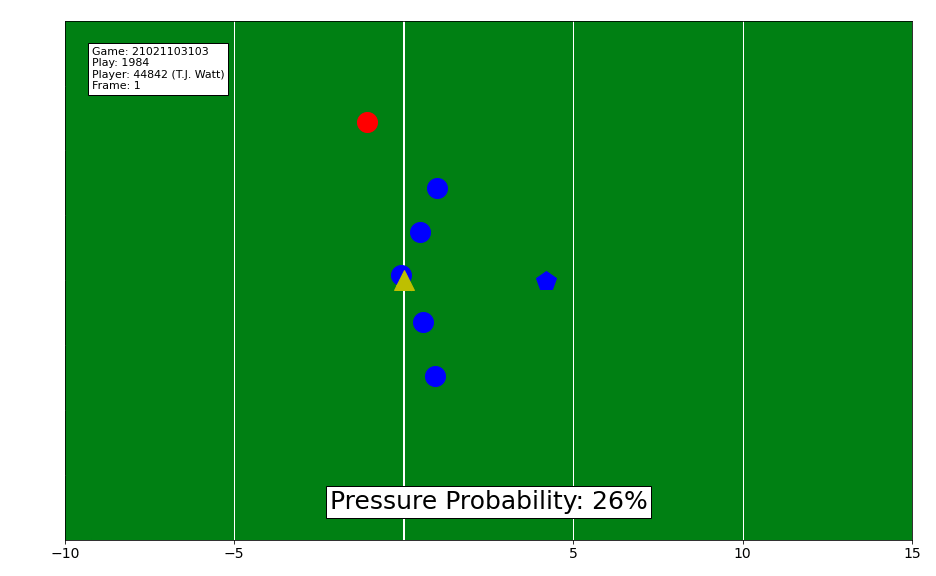

In [ ]:
path_plot(watt_rush1, watt_probs1, 21021103103, 1984, 44842, "T.J. Watt")

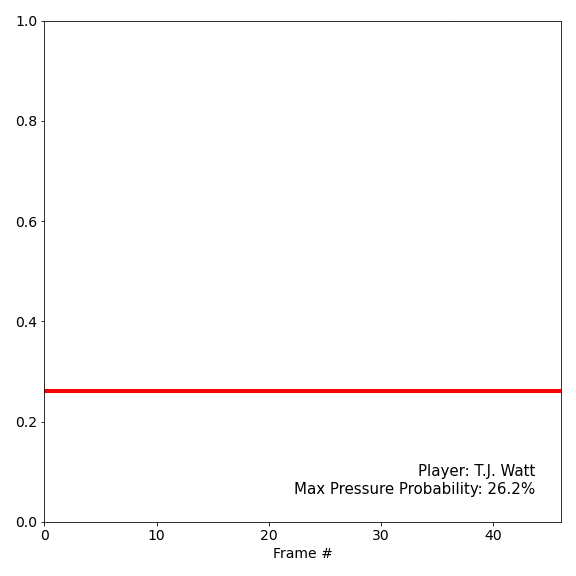

In [ ]:
prob_graph(watt_probs1, "T.J. Watt", 1984)

In [ ]:
watt_rush2, watt_probs2 = make_probs(df, mod2, 2021101711, 4396, 44842)

2/2 [==============================] - 0s 23ms/step


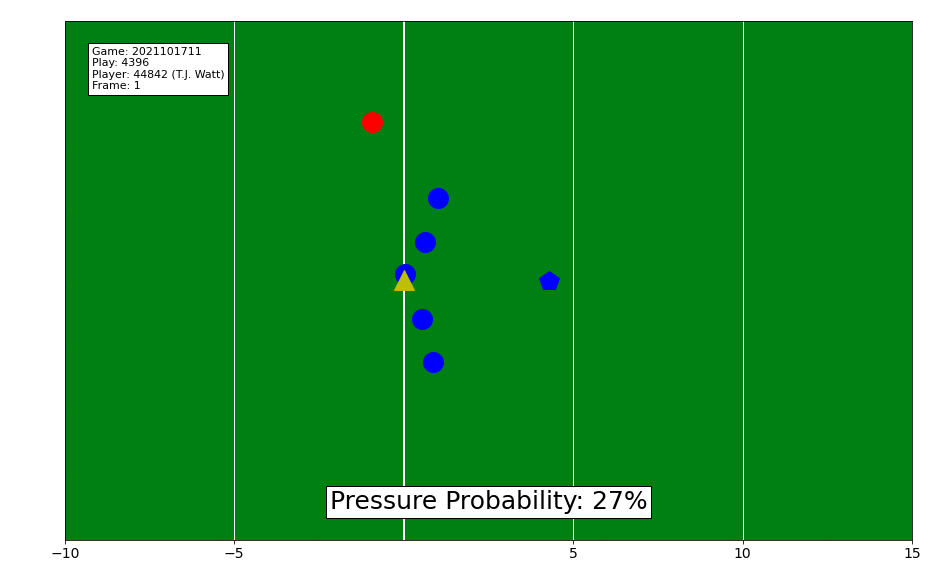

In [ ]:
path_plot(watt_rush2, watt_probs2, 2021101711, 4396, 44842, "T.J. Watt")

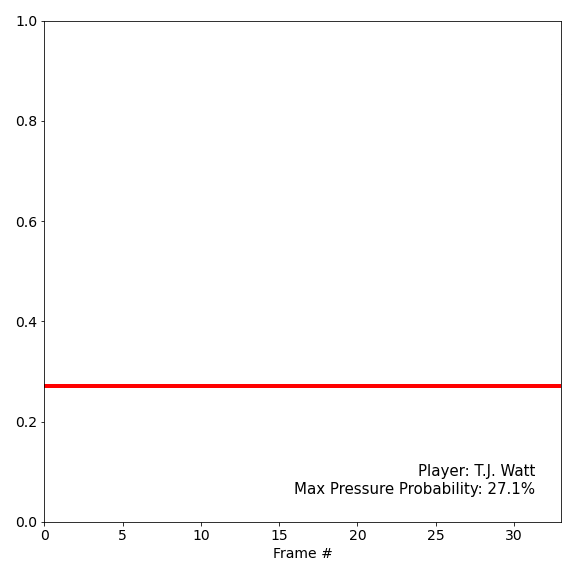

In [ ]:
prob_graph(watt_probs2, "T.J. Watt", 4396)

## LSTM-Transformer

In [ ]:
# def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
#     # Normalization and Attention
#     x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
#     x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
#     x = tf.keras.layers.Dropout(dropout)(x)
#     res = x + inputs

#     # Feed Forward Part
#     x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res)
#     x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
#     x = tf.keras.layers.Dropout(dropout)(x)
#     x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
#     return x + res

In [ ]:
# def model_transformer(data: list, head_size: int, num_heads: int, ff_dim: int, num_transformer_blocks: int, mlp_units: list,
#  mlp_dropout: float, dropout: float, lstm_units: int, num_epochs: int, val: float):
#   def build_model():
#     inputs = tf.keras.Input(shape=data[0].shape[1:])
#     x = inputs
#     x = tf.keras.layers.Masking(mask_value = -99.,input_shape = data[0].shape[1:])(x)
#     x = tf.keras.layers.LSTM(lstm_units, input_shape = data[0].shape[1:], return_sequences = True)(x)

#     for _ in range(num_transformer_blocks):
#         x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

#     x = tf.keras.layers.GlobalAveragePooling1D(data_format = "channels_last")(x)
#     x = tf.keras.layers.Dropout(0.1)(x)

#     for dim in mlp_units:
#         x = tf.keras.layers.Dense(dim, activation="relu")(x)
#         x = tf.keras.layers.Dropout(mlp_dropout)(x)

#     outputs = tf.keras.layers.Dense(data[2].shape[1], activation = "sigmoid")(x)
#     mod = tf.keras.Model(inputs, outputs)

#     mod.compile(
#         loss = "binary_crossentropy",
#         optimizer = "adam",
#         metrics = [tf.keras.metrics.AUC(), tf.keras.metrics.BinaryAccuracy()]
#     )
#     return mod

#   if in_colab:
#     strategy = tf.distribute.TPUStrategy(resolver)
#     with strategy.scope():
#       mod = build_model()
#   else:
#     mod = build_model()
    
#   callbacks = [tf.keras.callbacks.EarlyStopping(patience = 5, min_delta = 0.005,  monitor = "val_auc", restore_best_weights = True)]
#   mod.fit(data[0], data[2], epochs= num_epochs, validation_split = val, verbose = 1, callbacks = callbacks)

#   return mod